<a href="https://colab.research.google.com/github/nargeszaeri/buildingAnalysis/blob/master/Example_Time_Series_in_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, datasets, mixture
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# this is a subsection of the Kaggle ASHRAE competition that was held late last year
# which contains 3-year hourly energy data of over 1000 buildings in 15 locations across the globe
# link to competition: https://www.kaggle.com/c/ashrae-energy-prediction

df = pd.read_csv('https://raw.githubusercontent.com/ZixiaoShi/BuildingDataAnalytics/master/data/Kaggle_Site_7/building_energy.csv')

In [0]:
# this dataset is composed of many building meters and their meter readings
df.head()

,Unnamed: 0,building_id,meter,timestamp,meter_reading
0,959,789,1,2016-01-01 00:00:00,61.80
1,960,789,2,2016-01-01 00:00:00,454.63
2,961,790,1,2016-01-01 00:00:00,109.50
3,962,790,2,2016-01-01 00:00:00,803.57
4,963,791,0,2016-01-01 00:00:00,919.30


In [0]:
# let us examine how many buildings we have and how many meters in each building
# we can group by building_id and each of their meter and see how many non-empty readings each meter
# pandas allows us to do this very easily
# we are grouping the dataframe by two things, building_id first, and then by meter
df.groupby(['building_id', 'meter']).meter_reading.count()

building_id  meter
789          1        8590
             2        8590
790          1        8590
             2        8590
791          0        8784
             1        8595
             2        8595
792          1        8596
             2        8596
793          0        8782
             1        8779
             3        8782
794          0        8782
             1        8779
             3        8782
795          0        8780
             1        8779
             3        8780
796          0        8781
             1        8781
             2        8781
797          0        8781
             1        8781
             2        8781
798          0        8781
             1        8781
             2        8781
799          0        8781
             1        8781
             2        8759
800          0        8781
             1        8781
             2        8781
801          0        8781
             1        8781
             2        8781
802      

Most meters have at least 8500 hourly readings, which translate to one year of data. The data quality overall is quite good.

In [0]:
# let us choose one random building to perform some analysis
# unfortunately we don't know what kind of meter it is, but we could use visualization to differentiate them
bldg_df = df[df.building_id == 791]

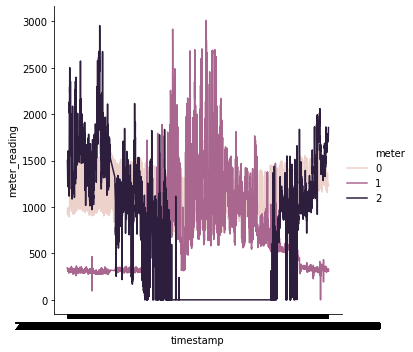

In [0]:
sns.relplot(x='timestamp', y='meter_reading', hue='meter', data=bldg_df, kind='line')

This plot took a while due to some inefficient sorting seaborn does. Still, you should be able to easily identify which meter belongs to heating, cooling or electrcity, right?


In [0]:
# ok let us extract one single meter from this data and do some clustering analysis
# from the previous analysis we know which one is the electricity meter
bldg_id = 791
meter_id = 0
cols_to_use = ['meter_reading', 'timestamp']
mask = (df.building_id == bldg_id) & (df.meter == meter_id)
meter_df = df.loc[mask, cols_to_use]

In [0]:
# and let us use timestamp as the dataframe index
# to do some timeseries magic by pandas
# first convert the timestamp column to actual timestamp data type
meter_df.timestamp = pd.to_datetime(meter_df.timestamp)
meter_df = meter_df.set_index('timestamp')

In [0]:
# let's take a look
meter_df.head()

,meter_reading
timestamp,
2016-01-01 00:00:00,919.30
2016-01-01 01:00:00,924.48
2016-01-01 02:00:00,934.85
2016-01-01 03:00:00,940.03
2016-01-01 04:00:00,965.95


In [0]:
# now time for some pandas timeseries magic
# let's see exaclt how many missing data we have in this time series
# we can do this by first set time series frequency to one hour
meter_df = meter_df.asfreq('1H')
# after this process, any missing timestamps are added to the timeseries
# and pandas will understand this timeseries is expected at 1-hr intervals

In [0]:
# again we can examine our index's datatype to see more details
# note this time the frequency says 'H' which means 1Hr
meter_df.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq='H')

In [0]:
# we can also use a different interval during resampling
# such as 3 hours, but this will cause us to loose some data
meter_df.asfreq('3H').head()

,meter_reading
timestamp,
2016-01-01 00:00:00,919.30
2016-01-01 03:00:00,940.03
2016-01-01 06:00:00,972.86
2016-01-01 09:00:00,967.68
2016-01-01 12:00:00,952.13


In [0]:
# now double check if there is missing timestamps in this dataset
gap_between_index = meter_df.index.shift() - meter_df.index
# so we have calculated the time gap between each index entry
# next by examining there is only one unique value in these gaps (1Hr difference)
# we can ensure this time series has a constant interval
gap_between_index.unique()

TimedeltaIndex(['01:00:00'], dtype='timedelta64[ns]', name='timestamp', freq=None)

In [0]:
# pandas can do some powerful filtering in time series
# for example, getting average electricity consumption at 7am
meter_df.loc[meter_df.index.hour == 7, 'meter_reading'].mean()

1190.2049453551906

In [0]:
# pretty neat, eh?
# we can do this further an look at average electricity consumption during Mondays between 9am to 5pm
mask = (meter_df.index.weekday == 0) & (meter_df.index.hour >=9 ) & (meter_df.index.hour <= 17)
meter_df.loc[mask, 'meter_reading'].mean()

1306.6413888888885

In [0]:
# for the sake of demonstration let us add three missing values to the dataset
meter_df.meter_reading[:3] = np.nan
# print the new data
meter_df.head()

,meter_reading
timestamp,
2016-01-01 00:00:00,NaN
2016-01-01 01:00:00,NaN
2016-01-01 02:00:00,NaN
2016-01-01 03:00:00,940.03
2016-01-01 04:00:00,965.95


# **Note pandas offers a wide range of tools to deal with missing data, especially in timeseries, more details are here: https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html**


In [0]:
# now let us aggregate the dataframe with missing data
# to downsample and get daily total energy consumption is easy
meter_df.resample('D').sum().head()

,meter_reading
timestamp,
2016-01-01,20006.78
2016-01-02,22859.70
2016-01-03,22864.91
2016-01-04,29752.72
2016-01-05,30777.40


In [0]:
# notice anything unusual?

In [0]:
# keep in mind when you sum up in Pandas, missing data is treated as zero by default (skipna=True)
# which could cause issues if one day has many hours of data missing
# instead, there are several options to solve this
# first option is to return a missing value when there is any hourly value missing downstream
meter_df.resample('D').agg(pd.Series.sum, skipna=False).head()

,meter_reading
timestamp,
2016-01-01,NaN
2016-01-02,22859.70
2016-01-03,22864.91
2016-01-04,29752.72
2016-01-05,30777.40


In [0]:
# or return missing when there are less than 21 valid values
meter_df.resample('D').agg(pd.Series.sum, min_count=21).head()

,meter_reading
timestamp,
2016-01-01,20006.78
2016-01-02,22859.70
2016-01-03,22864.91
2016-01-04,29752.72
2016-01-05,30777.40


In [0]:
# or do a hack, by getting hourly mean and then times 24
meter_df.resample('D').mean()*24

,meter_reading
timestamp,
2016-01-01,22864.891429
2016-01-02,22859.700000
2016-01-03,22864.910000
2016-01-04,29752.720000
2016-01-05,30777.400000
...,...
2016-12-27,29904.780000
2016-12-28,31129.910000
2016-12-29,30148.420000


In [0]:
# or using mean*24 with at most 2 missing values
# if any day has 2 missing vlaues or more, return empty
# note here we used something called apply and an lambda function
# lambda function is REALLY handy in Python to do complex logics
meter_df.resample('D').apply(lambda x: x.mean() if x.isnull().sum() <= 2 else np.nan)*24

,meter_reading
timestamp,
2016-01-01,NaN
2016-01-02,22859.70
2016-01-03,22864.91
2016-01-04,29752.72
2016-01-05,30777.40
...,...
2016-12-27,29904.78
2016-12-28,31129.91
2016-12-29,30148.42


For more pandas time series magic, visit their detailed tutorial https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

You can do a lot of complex things in a few simple lines of code. Such as converting timezones, replacing missing data, finding data gaps, grouping by week/day-type, etc.